# Chapter 4 - Dynamic Programming
This chapter considers one class of algorithms that can solve an RL problem (i.e. find an optimal policy) when the perfect model of the (finite) MDP is known. The authors mention that this is rarely the case in practice. However, ideas from Dynamic Programming are useful for more advanced RL techniques developed in the next chapters.

### Exercise 4.1

If $\pi$ is the equiprobable random policy, what is $Q^{\pi}(11, down)$? What is $Q^{\pi}(7, down)$?
<br>

From the Bellman equations we have:
$$
\begin{aligned}
    Q^{\pi}(s, a) &= \mathbb{E} \left[ r_{t+1} + \gamma V^{\pi} (s_{t+1}) \mid s_{t} = s, a_{t} = a \right] \\
    &= \sum_{s'} \mathcal{P}_{ss'}^{a} \left( \mathcal{R}_{ss'}^{a} + \gamma V^{\pi} (s') \right)
\end{aligned}
$$

Given the gridworld definition and values in Figure 4.2 (left), $s_{t} = 11 \text{ and } a_{t} = down \text{ imply } s_{t+1} = terminal \text{ , } r_{t+1} = -1 \text{ and } V^{\pi} (terminal) = 0 \text{ , so } \boxed{Q^{\pi}(11, down) = 1 \cdot \left( -1 + \gamma \cdot 0 \right) = -1}$.
<br>

Similarly, $\boxed{ Q^{\pi}(7, down) = 1 \cdot \left( -1 + \gamma V^{\pi}(11) \right) = -15}$.

### Exercise 4.2
Suppose a new state $15$ is added below state $13$, and the actions $left$, $up$, $right$ and $down$ take the agent to states $12$, $13$, $14$ and $15$, respectively. 
- If transitions _from_ the original states are unchanged, what is $V^{\pi}(15)$ for the equiprobable random policy?
- If the dynamics of state $13$ are changed such that $\mathcal{P}_{13 \to 15}^{down} = 1$, what is $V^{\pi}(15)$ for the same policy?
<br>

__Answers__:
<br>
- when the transitions from the original states don't change, it means that their state-values don't change either, since state $15$ is unreachable from any other state. In particular, $(s_t = 13, a_t = down) \longrightarrow s_{t+1} = 13$. So it's easy to calculate:
$$
\begin{aligned}
    V^{\pi}(15) &= \frac{1}{4} \left[ (-1 + \gamma V^{\pi}(12)) + (-1 + \gamma V^{\pi}(13)) + (-1 + \gamma V^{\pi}(14)) + (-1 + \gamma V^{\pi}(15)) \right] \\
    &= \frac{1}{4} \left[ -4 + V^{\pi}(12) + V^{\pi}(13) + V^{\pi}(14) \right] + \frac{1}{4} V^{\pi}(15) \\
    &= \frac{4}{3} \cdot \frac{1}{4} \left[ -4 + V^{\pi}(12) + V^{\pi}(13) + V^{\pi}(14) \right] \\
    &= \frac{1}{3} \cdot (-60) \\
    &= \boxed{-20} \\
\end{aligned}
$$

- when the transition from state $13$ with action $down$ leads to state $15$, we should have to reevaluate $V^{\pi}(13)$ in particular and iteratively all the other states as per the algorithm in __Figure 4.1__, since they are interdependent. We eliminate $\gamma$ to simplify the equations, since this task is undiscounted, i.e. $\gamma = 1$. We start by reevaluating $V^{\pi}(13)$ by including the value of $V^{\pi}(15)$ calculated above:
$$
\begin{aligned}
    V^{\pi}(13) &= \frac{1}{4} \left[ (-1 + V^{\pi}(12)) + (-1 + V^{\pi}(9)) + (-1 + V^{\pi}(14)) + (-1 + V^{\pi}(15)) \right] \\
    &= \frac{1}{4} \left[ (-23) + (-21) + (-15) + (-21) \right] \\
    &= -20 \\
\end{aligned}
$$
So luckily in this case, the value of $V^{\pi}(13)$ remains the same, which means that all other state-values remain the same, including $\boxed{V^{\pi}(15) = -20}$.

### Exercise 4.3
What are the equations analogous to (4.3), (4.4) and (4.5) for the action-value function $Q^{\pi}$ and its successive approximation by a sequence of functions $Q_{0}$, $Q_{1}$, $Q_{2}$,...?

Let's start from the Bellman equation for $Q^{\pi}$ (see exercise 3.8):
$$
\begin{aligned}
    Q^{\pi}(s, a) &= \mathbb{E}_{\pi} \left[ r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... \mid s_{t} = s, a_{t} = a \right] \\
    & = ... \\
    & = \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^{a} \left( \mathcal{R}_{ss'}^{a} + \gamma \sum_{a' \in \mathcal{A(s')}} \pi(s', a') \cdot Q^{\pi} (s', a') \right) \\
\end{aligned}
$$

Now in order to successively approximate $Q^{\pi}$ starting from some initial guess $Q_{0}^{\pi}$, we can write:
$$
\begin{aligned}
    Q_{k+1}^{\pi}(s, a) & = \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^{a} \left( \mathcal{R}_{ss'}^{a} + \gamma \sum_{a' \in \mathcal{A(s')}} \pi(s', a') \cdot Q_{k}^{\pi} (s', a') \right) \text{, for all } k \geq 0.\\
\end{aligned}
$$

### Exercise 4.4 (programming)
Solve Jack's Car Rental problem.
<br>
First I reproduce the solution as in Figure 4.4, then I rerun with the non-linearities mentioned in Exercise 4.4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Precompute the MDP state transitions and rewards (without costs)
For this MDP of type $\Big\{(n^1_{t}, n^2_{t}),\: a_t \Big\} \longrightarrow \Big\{(n^1_{t+1}, n^2_{t+1}),\: r^1_{t+1}+r^2_{t+1} \Big\}$, <br>we can decompose it into two smaller MDPs: 
$\Big\{n^1_t,\: a_t \Big\} \longrightarrow \Big\{n^1_{t+1},\: r^1_{t+1} \Big\}$ and $\Big\{n^2_t,\: -a_t \Big\} \longrightarrow \Big\{n^2_{t+1},\: r^2_{t+1} \Big\}$, where $n^i_t$ is the number of cars at the end of day $t$ in location $i$, $a$ is the number of cars moved between location $1$ and $2$ and $r_t^i$ is the credit received for cars rented out on day $t$ in location $i$. This "decomposition" is only possible because the states of locations $1$ and $2$ are not influenced between them other than by the action $a$. Once $a$ is given, the two MDPs behave according to their individual stochastic characteristics, i.e. their respective lambdas of the Poisson distributions, independently one from another. This is only a computation / memory optimisation; in theory the full MDP transitions could be calculated and have the same outcome as the combined two.
<br>
<br>

The two smaller MDPs are efficiently precalculated and stored in two nested hash tables, specifically the state probability transitions and expected rewards, i.e. $\mathcal{P}_{nn'}^{a}$ and $\mathcal{R}_{nn'}^{a}$. Costs are not included in the rewards at this stage in order to be able to control them at runtime.

In [196]:
def poisson_pmf(n, lam):
    # probability that n customers rent / return a car, given respective lambda
    return np.power(lam, n) * np.exp(-lam) / np.math.factorial(n)

def precompute_mdp_state_transitions(max_cars=20, lambda_rent=3, lambda_return=3, extra_parking_cost=0):
    mdp = dict()
    for n in range(max_cars + 1):
        mdp[n] = dict()
        for a in range(-5, 6, 1):
            if n - a >= 0: # only consider legal moves
                mdp[n][a] = dict()
                for demand in range(max_cars + 1):
                    for returns in range(max_cars + 1):
                        n_next = min(max(min(n - a, max_cars) - demand, 0) + returns, max_cars)
                        p = poisson_pmf(n=demand, lam=lambda_rent) * poisson_pmf(n=returns, lam=lambda_return)
                        r = 10 * min(min(n - a, max_cars), demand)  # $10 per car rented out
                        if n - a > 10:
                            r -= extra_parking_cost  # additional parking lot
                            # add moving cost at runtime as it is common to both locations
                        if n_next not in mdp[n][a]:
                            mdp[n][a][n_next] = dict(P=0., R=0.)
                        mdp[n][a][n_next]['P'] += p
                        mdp[n][a][n_next]['R'] += p * r
                for n_next in mdp[n][a]:
                    mdp[n][a][n_next]['R'] /= mdp[n][a][n_next]['P']
    return mdp

mdp1 = precompute_mdp_state_transitions(max_cars=20, lambda_rent=3, lambda_return=3)
mdp2 = precompute_mdp_state_transitions(max_cars=20, lambda_rent=4, lambda_return=2)

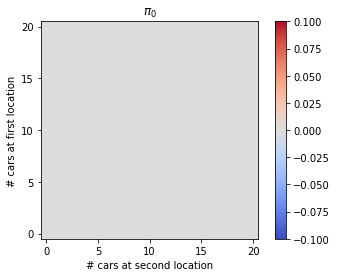

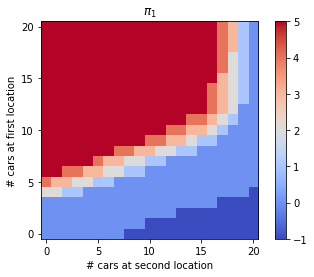

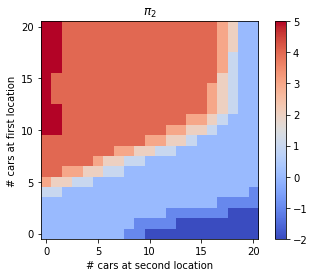

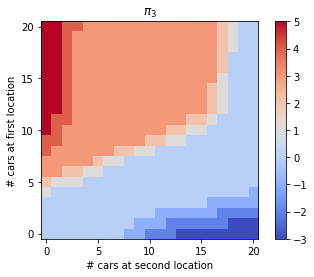

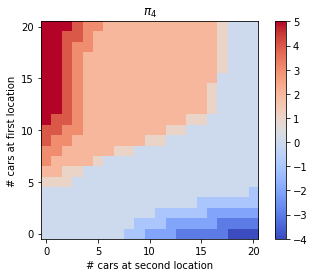

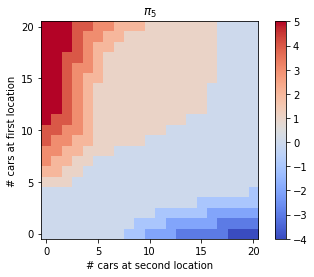

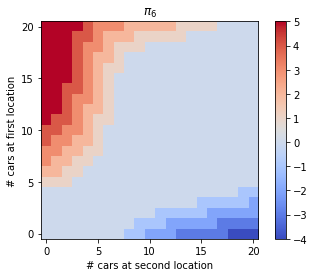

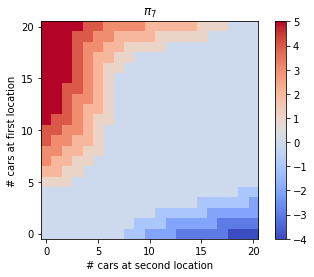

In [197]:
max_cars = 20
action_space = np.arange(-5, 6, 1)
gamma = 0.9
theta = 1.e-5

# initiate policy pi with zeros (i.e. pi(s, 0) = 1 for all s, and pi(s, a) = 0 for all a <> 0)
pi = np.zeros((max_cars + 1, max_cars + 1))
# initiate V_pi with zeros
V_pi = np.zeros((max_cars + 1, max_cars + 1))


# Policy evaluation
def policy_evaluation_loop(pi, V_pi, employee_shuttle=False):
    delta = 0.
    # loop through all states
    for n1 in range(max_cars + 1):
        for n2 in range(max_cars + 1):
            # action if policy pi is followed
            a = pi[n1, n2]
            # make sure it's a legal move
            if (a == 0) or (0 < a and a <= n1) or (a < 0 and a >= -n2):
                moving_cost = 2 * abs(a)
                if employee_shuttle and a > 0:
                    moving_cost -= 2
                new_v = 0.
                # for each possible s'
                for n1_next in mdp1[n1][a]:
                    for n2_next in mdp2[n2][-a]:
                        new_v += (
                            mdp1[n1][a][n1_next]['P']  
                            * mdp2[n2][-a][n2_next]['P'] 
                            * (
                                mdp1[n1][a][n1_next]['R']
                                + mdp2[n2][-a][n2_next]['R']
                                - moving_cost
                                + gamma * V_pi[n1_next, n2_next]
                            )
                        )
                delta = max(delta, abs(V_pi[n1, n2] - new_v))
                # update V(s)
                V_pi[n1, n2] = new_v
    return delta, V_pi


def policy_improvement_loop(pi, V, employee_shuttle=False):
    policy_stable = True
    # loop through all states
    for n1 in range(max_cars + 1):
        for n2 in range(max_cars + 1):
            b = pi[n1, n2]
            for a in action_space:
                # evaluate only a != b and don't move more cars than present
                if (a != b) and ((a == 0) or (0 < a and a <= n1) or (a < 0 and a >= -n2)):
                    moving_cost = 2 * abs(a)
                    if employee_shuttle and a > 0:
                        moving_cost -= 2
                    new_v = 0.
                    # for each possible s'
                    for n1_next in mdp1[n1][a]:
                        for n2_next in mdp2[n2][-a]:
                            new_v += (
                                mdp1[n1][a][n1_next]['P']
                                * mdp2[n2][-a][n2_next]['P']
                                * (
                                    mdp1[n1][a][n1_next]['R']
                                    + mdp2[n2][-a][n2_next]['R']
                                    - moving_cost
                                    + gamma * V_pi[n1_next, n2_next]
                                )
                            )
                    if new_v > V[n1, n2]:
                        pi[n1, n2] = a
                        policy_stable = False
    return policy_stable, pi

# Run policy iteration loops until stable (or max k=20)
policy_stable = False
k = 0
while not policy_stable and k < 20:
    evaluation_complete = False
    while not evaluation_complete:
        delta, V_pi = policy_evaluation_loop(pi, V_pi)
        if delta < theta:
            evaluation_complete = True

    # plot every improvement of policy pi (or less frequent if desired)
    if k % 1 == 0:
        plt.imshow(pi, origin='lower', cmap='coolwarm')
        plt.ylabel('# cars at first location')
        plt.xlabel('# cars at second location')
        plt.xticks([0, 5, 10, 15, 20])
        plt.yticks([0, 5, 10, 15, 20])
        plt.title(f'$\pi_{k}$')
        plt.colorbar()
        plt.show()

    policy_stable, pi = policy_improvement_loop(pi, V_pi)
    k += 1

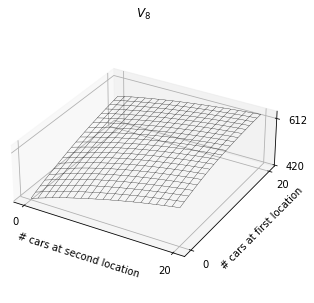

In [198]:
ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d', box_aspect=(3, 3, 1))
ax.view_init(elev=30, azim=-60, vertical_axis='z')
grid = np.meshgrid(np.arange(0, 21, 1), np.arange(0, 21, 1))
ax.plot_wireframe(grid[0], grid[1], V_pi, color='black', linewidth=0.3)
ax.set_ylabel('# cars at first location')
ax.set_xlabel('# cars at second location')
ax.set_xticks([0, 20])
ax.set_yticks([0, 20])
ax.set_zticks([420, 612])
ax.set_title(f'$V_{k}$')
plt.show()

Below it's the same problem but with the additional constraints from Exercise 4.4.

In [191]:
# recompute the MDPs with the extra parking cost
mdp1 = precompute_mdp_state_transitions(max_cars=20, lambda_rent=3, lambda_return=3, extra_parking_cost=4)
mdp2 = precompute_mdp_state_transitions(max_cars=20, lambda_rent=4, lambda_return=2, extra_parking_cost=4)

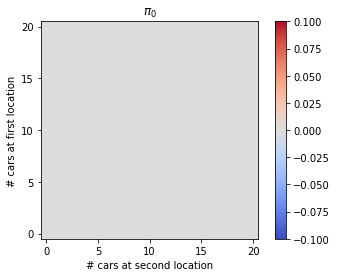

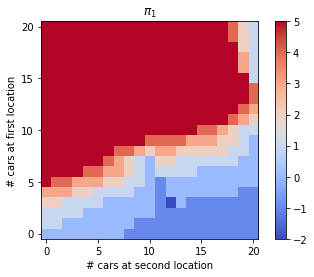

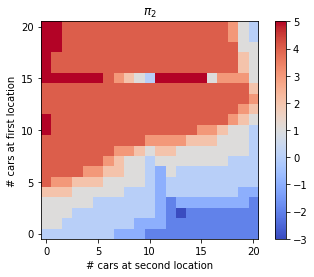

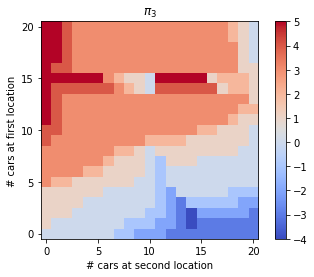

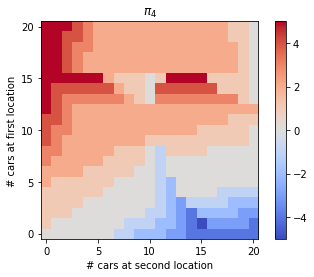

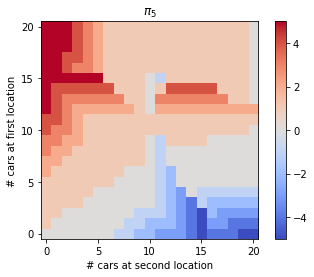

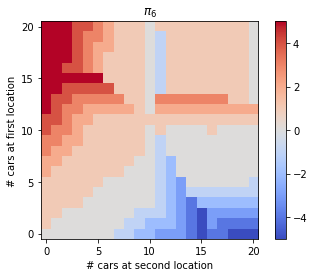

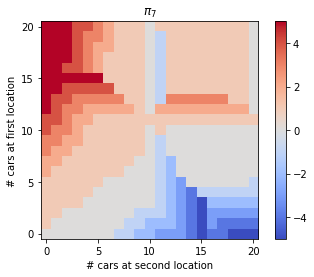

In [194]:
# initiate policy pi with zeros (i.e. pi(s, 0) = 1 for all s, and pi(s, a) = 0 for all a <> 0)
pi = np.zeros((max_cars + 1, max_cars + 1))
# initiate V_pi with zeros
V_pi = np.zeros((max_cars + 1, max_cars + 1))

# Run policy iteration loops until stable (or max k=20)
policy_stable = False
k = 0
while not policy_stable and k < 20:
    evaluation_complete = False
    while not evaluation_complete:
        delta, V_pi = policy_evaluation_loop(pi, V_pi, employee_shuttle=True)
        if delta < theta:
            evaluation_complete = True

    # plot every improvement of policy pi (or less frequent if desired)
    if k % 1 == 0:
        plt.imshow(pi, origin='lower', cmap='coolwarm')
        plt.ylabel('# cars at first location')
        plt.xlabel('# cars at second location')
        plt.xticks([0, 5, 10, 15, 20])
        plt.yticks([0, 5, 10, 15, 20])
        plt.title(f'$\pi_{k}$')
        plt.colorbar()
        plt.show()

    policy_stable, pi = policy_improvement_loop(pi, V_pi, employee_shuttle=True)
    k += 1

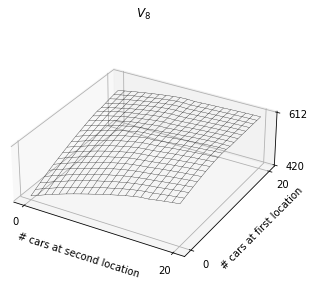

In [195]:
ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d', box_aspect=(3, 3, 1))
ax.view_init(elev=30, azim=-60, vertical_axis='z')
grid = np.meshgrid(np.arange(0, 21, 1), np.arange(0, 21, 1))
ax.plot_wireframe(grid[0], grid[1], V_pi, color='black', linewidth=0.3)
ax.set_ylabel('# cars at first location')
ax.set_xlabel('# cars at second location')
ax.set_xticks([0, 20])
ax.set_yticks([0, 20])
ax.set_zticks([420, 612])
ax.set_title(f'$V_{k}$')
plt.show()

### Exercise 4.5
Give a complete algorithm analogous to Figure 4.3 for computing $Q^*$.

$$
\boxed {
    \begin{align*}
        \large 1.\: & \text{\large Initialization} \\
        &Q(s, a) \in \mathfrak{R} \text { and } \pi (s, a) \in [0, 1] \text { arbitrarily for all } (s, a) \in \mathcal{S} \times \mathcal{A} \text{, such that } \sum_a \pi (s, a) = 1 \\
        \\ \\

        \large 2.\: & \text{\large Policy Evaluation} \\
        &\text {Repeat} \\
        &\qquad \Delta \leftarrow 0 \\
        &\qquad \text {For each } s \in \mathcal{S} \\
        &\qquad \qquad \text {For each } a \in \mathcal{A}(s) \\
        &\qquad \qquad \qquad q \leftarrow Q(s, a) \\
        &\qquad \qquad \qquad Q(s, a) \leftarrow \sum_{s'} \mathcal{P}_{ss'}^{a} \left[ \mathcal{R}_{ss'}^{a} + \gamma \sum_{a' \in \mathcal{A}(s')} \pi (s', a') \cdot Q(s', a') \right] \\
        &\qquad \qquad \qquad \Delta \leftarrow \max (\Delta, \lvert q - Q(s, a) \rvert) \\
        &\text {until } \Delta \lt \theta \text { \: (a small positive number)} \\
        \\ \\

        \large 3.\: & \text{\large Policy Improvement} \\
        &policy\text{-}stable \leftarrow \text{true} \\
        &\text {For each } s \in \mathcal{S} \\
        &\qquad b \leftarrow \text{array} \left[ \pi(s, \cdot) \right] \\
        &\qquad A^{max}(s) \leftarrow \underset{a \in \mathcal{A}(s)}{\arg\max} \: Q(s, a) \\
        &\qquad \pi(s, a) \leftarrow \begin{cases}
            \frac {1} {\lvert A^{max}(s) \rvert} && \text{ if } a \in A^{max}(s) \\
            0 && \text{ otherwise } \\
            \end{cases} \\
        &\qquad \text {If } b \neq \text{array} \left[ \pi(s, \cdot) \right] \text {, then } policy\text{-}stable \leftarrow \text{false} \\
        &\text {If } policy\text{-}stable, \text{ then stop; else go to 2} \\
    \end{align*}
}
$$
<br>
<br>

__Note 1__: $A^{max}(s)$ is the set of all actions $a$ which maximize $Q(s, a)$, not (necessarily) a single action.
<br>
<br>

__Note 2__: Checking if the policy is stable or not, i.e. $b \neq \text{array} \left[ \pi(s, \cdot) \right]$ should be implemented as an approximation, for instance when:
$$D_{\text{KL}}(\pi(s, \cdot) \: \Vert \: b) < \epsilon \text { \: (a small positive number)}$$

### Exercise 4.6
Consider $\epsilon\text{-}soft$ policies. Describe qualitatively the changes required for the policy iteration algorithm for $V^*$ in Figure 4.3.
<br>
<br>

__Answer__:
<br>
At step _3. Policy Improvement_, the policy $\pi(s)$ should become a probability distribution over all $a \in \mathcal{A}(s)$. If we consider $\mathcal{A}^{max}(s)$ the set of all actions $a$ which maximize the expression $\sum_{s'} \mathcal{P}_{ss'}^a \left[ \mathcal{R}_{ss'}^a + \gamma V(s') \right]$, then the update step becomes:

$$\pi(s, a) \leftarrow \begin{cases}
            \frac {1 - \epsilon} {\lvert \mathcal{A}^{max}(s) \rvert} + \frac {\epsilon} {\lvert \mathcal{A}(s) \rvert} && \text{ if } a \in \mathcal{A}^{max}(s) \\
            \frac {\epsilon} {\lvert \mathcal{A}(s) \rvert} && \text{ otherwise } \\
            \end{cases} \\
$$
It's straightforward then to show that $\sum_{a \in \mathcal{A}(s)} \pi(s, a) = 1$.
<br>
<br>

At step _2. Policy Evaluation_, the $V(s)$ update should become: 

$$
V(s) \leftarrow \sum_{a} \pi (s, a) \sum_{s'} \mathcal{P}_{ss'}^{a} \left[ \mathcal{R}_{ss'}^{a} + \gamma V(s') \right]
$$
<br>
<br>

At step _1. Initialization_, as discussed above, $\pi(s)$ becomes a distribution over all actions, i.e. $\pi(s, a) \in [0, 1]$, assigned arbitrarily such that $\sum_{a \in \mathcal{A}(s)} \pi(s, a) = 1$ for all $s \in \mathcal{S}$.

### Exercise 4.7
See plots and notes from Exercise 4.8 below, as well as the official Errata.
The shape of the optimal policy is not unique, in fact there is an entire family of optimal policies, depending on how one breaks ties. However the optimal value of $\pi(s=50) = 50$ versus $\pi(s=51) = 1$ seems to depend on the discrete nature of the problem, as it seems to lead to tiny "nooks" in the shape of $V$ at states $s = \frac {100} {2^k}$. One can verify that:
$$
    Q(s=51, a=49) = p V(s=100) + (1-p) V(s=2) \lt p V(s=52) + (1-p) V(s=50) = Q(s=51, a=1)
$$
This is due to the overall convex shape of $V$ for any $p < 0.5$, with the exception of the "nooks" mentioned above.

### Exercise 4.8
Implement the Gambler's Problem.

In [199]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [272]:
# Let's define the MDP variables
#================================
# s, s' := states, i.e. the gambler's capital from S = {1, 2, ..., 99} union the terminals {0, 100}

# a := action, the gambler's bet at each state s. A(s) = {1, 2, ..., min(s, 100-s)}

# R_{ss'}^a := 0 for all s' != s100 
#           := 1 for s' == s100

# P_{ss'}^a := p for s' = (s+a), for all s in non-terminal states
#           := (1-p) for s' = (s-a), for all s in non-terminal states
#           := 0 for any other s, s'

In [372]:
# Value Iteration algorithm (Figure 4.5)
#---------------------------------------
def gambler_value_iteration(p):
    # Initialisations
    V = np.zeros(101)
    R = np.zeros(101)
    R[100] = 1
    gamma = 1
    theta = 1e-19

    # Policy evaluation
    sweep = 0
    V_sweep = dict()
    evaluation_complete = False
    while not evaluation_complete:
        delta = 0.
        if sweep in [1, 2, 3, 32]:  # store just the ones in Figure 4.6
            V_sweep[sweep] = V.copy()

        for s in range(1, 100):
            v = V[s]
            max_v = -1
            for a in range(min(s, 100-s), 0, -1):
                s_next_won = s + a
                s_next_lost = s - a
                new_v_a = (
                    p * (R[s_next_won] + gamma * V[s_next_won])
                    + (1-p) * (R[s_next_lost] + gamma * V[s_next_lost])
                )
                if new_v_a >= max_v:
                    max_v = new_v_a
            V[s] = max_v
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            evaluation_complete = True
        sweep += 1

    # Output Policy
    pi = np.ones(101)
    pi[0] = 0
    pi[100] = 0
    for s in range(1, 100):
        max_v = -1
        for a in range(min(s, 100-s), 0, -1):
            s_next_won = s + a
            s_next_lost = s - a
            new_v_a = (
                p * (R[s_next_won] + gamma * V[s_next_won])
                + (1-p) * (R[s_next_lost] + gamma * V[s_next_lost])
            )
            if new_v_a >= max_v:
                    max_v = new_v_a
                    pi[s] = a
    return V, pi, V_sweep

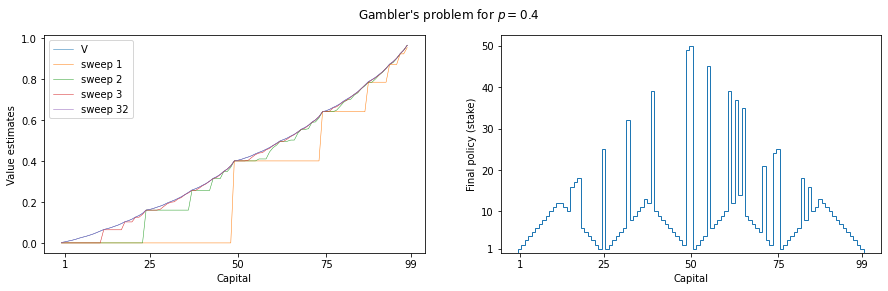

In [402]:
# Replicate Figure 4.6
p=0.4
V, pi, V_sweep = gambler_value_iteration(p=p)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].plot(V[1:-1], label='V', linewidth=0.5)
for sweep in V_sweep:
    ax[0].plot(V_sweep[sweep][1:-1], label=f'sweep {sweep}', linewidth=0.5)
ax[0].set_xticks([1, 25, 50, 75, 99])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Value estimates')
ax[0].legend()

ax[1].stairs(pi[1:-1], np.arange(0, 100) + 0.5)
ax[1].set_xticks([1, 25, 50, 75, 99])
ax[1].set_yticks([1, 10, 20, 30, 40, 50])
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Final policy (stake)')

fig.suptitle(f"Gambler's problem for $p = {p}$")
plt.show()

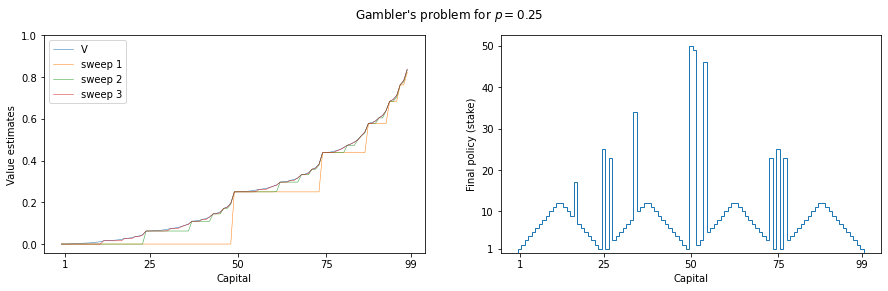

In [389]:
p=0.25
V, pi, V_sweep = gambler_value_iteration(p=p)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].plot(V[1:-1], label='V', linewidth=0.5)
for sweep in V_sweep:
    ax[0].plot(V_sweep[sweep][1:-1], label=f'sweep {sweep}', linewidth=0.5)
ax[0].set_xticks([1, 25, 50, 75, 99])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Value estimates')
ax[0].legend()

ax[1].stairs(pi[1:-1], np.arange(0, 100) + 0.5)
ax[1].set_xticks([1, 25, 50, 75, 99])
ax[1].set_yticks([1, 10, 20, 30, 40, 50])
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Final policy (stake)')

fig.suptitle(f"Gambler's problem for $p = {p}$")
plt.show()

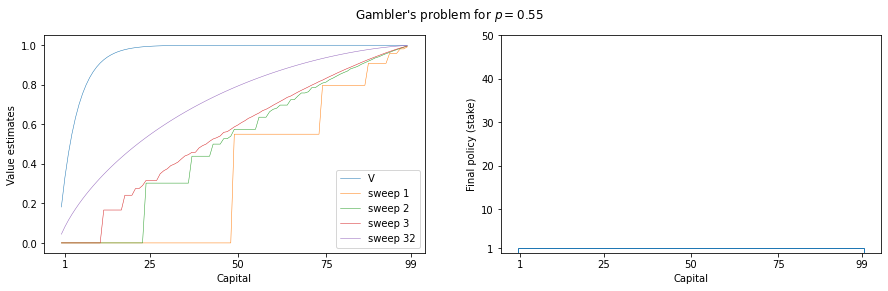

In [392]:
# Notice the concave shape of V function
# and optimal action = bet $1 in all states
# when p > 0.5

p=0.55
V, pi, V_sweep = gambler_value_iteration(p=p)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].plot(V[1:-1], label='V', linewidth=0.5)
for sweep in V_sweep:
    ax[0].plot(V_sweep[sweep][1:-1], label=f'sweep {sweep}', linewidth=0.5)
ax[0].set_xticks([1, 25, 50, 75, 99])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Value estimates')
ax[0].legend()

ax[1].stairs(pi[1:-1], np.arange(0, 100) + 0.5)
ax[1].set_xticks([1, 25, 50, 75, 99])
ax[1].set_yticks([1, 10, 20, 30, 40, 50])
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Final policy (stake)')

fig.suptitle(f"Gambler's problem for $p = {p}$")
plt.show()

### Exercise 4.9
Write the analog of the value iteration backup (equation 4.10) for action values $Q_{k+1}(s, a)$.

Let's begin from the iterative equation for estimating $Q^*$ from Exercise 4.3:
$$
Q_{k+1}^{\pi}(s, a) = \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^{a} \left( \mathcal{R}_{ss'}^{a} + \gamma \sum_{a' \in \mathcal{A(s')}} \pi(s', a') \cdot Q_{k}^{\pi} (s', a') \right)
$$
Since we want to update $Q_{k+1}(s, a)$ in a single (or truncated) policy evaluation sweep, instead of following $\pi(s', a')$, we'll have to simply choose the action that maximizes $Q_{k}(s', \cdot)$, thus the update equation becomes:

$$
Q_{k+1}(s, a) = \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^{a} \left( \mathcal{R}_{ss'}^{a} + \gamma \max_{a' \in \mathcal{A(s')}} Q_{k} (s', a') \right)
$$
Notice I removed the superscript $\pi$ from $Q$ since we're updating it greedily by disregarding the probability distribution of $\pi(s', \cdot)$.

### Second Edition
There are no significant differences in the 2nd edition for this chapter (other than the changed notation already discussed in the previous notebook for Chapter 3).